<a href="https://colab.research.google.com/github/psyuktha/skimlit/blob/main/abstract_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 27.07 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
data_dir='content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# prompt: function to read lines of a document

def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()


In [ ]:
train=get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
#preprocess the data as dictionary with labels and features
def preprocess(filename):
  input=get_lines(filename)
  abstract=''
  abstract_samples=[]
  for i in input:
    if i.startswith("###"):
      astract_id=i
      abstract=''
    elif i.isspace():
      abstract_line_split=abstract.splitlines()
      for line_no,line in enumerate(abstract_line_split):
        line_data={}
        target=line.split("\t")
        line_data['target']=target[0]
        line_data['text']=target[1]
        line_data['line_no']=line_no
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract+=i

  return abstract_samples





In [ ]:
train_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
test_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)


In [ ]:
train_sentences=train_df['text'].tolist()
test_sentences=test_df['text'].tolist()


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

55

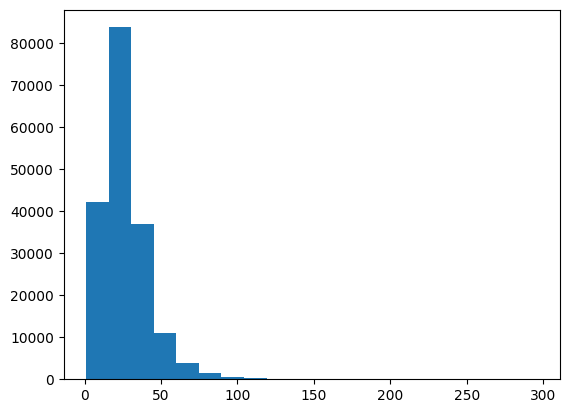

In [ ]:
#finding the output sequence length for the vectorisation layer
import matplotlib.pyplot as plt
s=[len(sentence.split()) for sentence in train_sentences]
plt.hist(s,bins=20)
op_len = int(np.percentile(s,95))
op_len

In [ ]:
text_vectorizer = TextVectorization( max_tokens = 68000, output_sequence_length=op_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
vocab_20 = text_vectorizer.get_vocabulary()
print(f"no of words {len(vocab_20)}")
print(f"common words {vocab_20[:5]}")
print(f"least common words {vocab_20[-5:]}")


no of words 64841
common words ['', '[UNK]', 'the', 'and', 'of']
least common words ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
token_embed = layers.Embedding(input_dim=len(vocab_20),
                                             output_dim=128,
                                             mask_zero= True,
                                             name='token_embedding')

In [ ]:
#creating labels
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
one_hot=OneHotEncoder(sparse=False)
train_label_hot=one_hot.fit_transform(tf.expand_dims(train_df['target'],axis=-1))
test_label_hot=one_hot.fit_transform(tf.expand_dims(test_df['target'],axis=-1))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_label_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
train_chars=[split_chars(i) for i in train_sentences]
test_chars=[split_chars(i) for i in test_sentences]



290

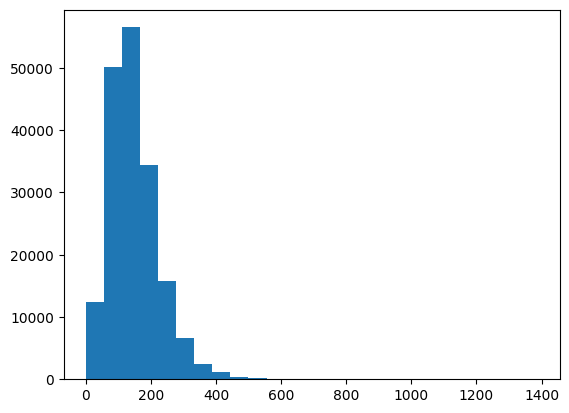

In [ ]:
#character level tokenisation
char_lens = [len(i) for i in train_sentences]
plt.hist(char_lens,bins=25)
perc_len=int(np.percentile(char_lens,95))
perc_len

In [ ]:
#get all keyboard characters
import string
alpha = string.ascii_lowercase + string.digits +string.punctuation

In [ ]:
#create char level tokenisation
num_char_tokens= len(alpha)+2 #space and oov(out of vocab,[UNK])
char_vectorizer=TextVectorization(max_tokens=num_char_tokens,
                                  output_sequence_length=perc_len,
                                  name='char_vectorizer')
#set standardization to None if to include ounctuation marks

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                                             output_dim=25,
                                             mask_zero= True,
                                             name='char_embedding')

In [ ]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_label_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_label_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# multi modal model with words vectorisation and character vectorisation
token_inputs = layers.Input(shape=(1,),dtype=tf.string, name='token_input')
token_vectors=text_vectorizer(token_inputs)
token_embeddings=token_embed(token_vectors)
token_output=layers.Dense(128,activation='relu')(token_embeddings)
token_output=layers.Flatten()(token_output)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)

char_inputs = layers.Input(shape=(1,),dtype=tf.string, name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

token_char_concat=tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                       char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(5,activation="softmax")(final_dropout)

model=tf.keras.Model(inputs=[token_model.input, char_model.input],
                       outputs=output_layer,
                       name='hybrid_model')




In [ ]:
model.compile(loss='categorical_crossentropy',
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
               )


In [ ]:
model.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding (Embedding  (None, 55, 128)              8299648   ['text_vectorizatio

In [ ]:
#combine chars and tokens into a dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))#make data
train_char_token_label=tf.data.Dataset.from_tensor_slices(train_label_hot)#make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_label))

train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))#make data
test_char_token_label=tf.data.Dataset.from_tensor_slices(test_label_hot)#make labels
test_char_token_dataset=tf.data.Dataset.zip((test_char_token_data,test_char_token_label))

test_char_token_dataset=test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset,test_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history=model.fit(train_char_token_dataset,
                      steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                                              epochs=3,
                      validation_data=test_char_token_dataset,
                      validation_steps = int(0.1*len(test_char_token_dataset))
                                              )


Epoch 1/3
562/562 [==============================] - 353s 605ms/step - loss: 0.9282 - accuracy: 0.6257 - val_loss: 0.6267 - val_accuracy: 0.7573
Epoch 2/3
562/562 [==============================] - 294s 523ms/step - loss: 0.6715 - accuracy: 0.7506 - val_loss: 0.5989 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 299s 532ms/step - loss: 0.6425 - accuracy: 0.7649 - val_loss: 0.5655 - val_accuracy: 0.7786


In [ ]:
model.evaluate(test_char_token_dataset)

942/942 [==============================] - 68s 72ms/step - loss: 0.5783 - accuracy: 0.7863


[0.5782727003097534, 0.786261796951294]